<a href="https://colab.research.google.com/github/ML-HW-SYS/a2-WDaugherty/blob/main/6_pruning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **6. Model Pruning**

## 6.0 Setup GDrive and Git

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
# Make sure your token is stored in a txt file at the location below.
# This way there is no risk that you will push it to your repo
# Never share your token with anyone, it is basically your github password!
with open('/content/gdrive/MyDrive/ece5545/token.txt') as f:
    token = f.readline().strip()
# Use another file to store your github username    
with open('/content/gdrive/MyDrive/ece5545/git_username.txt') as f:
    handle = f.readline().strip()

In [ ]:
# Clone your github repo
YOUR_TOKEN = token
YOUR_HANDLE = handle
BRANCH = "main"

%mkdir /content/gdrive/MyDrive/ece5545
%cd /content/gdrive/MyDrive/ece5545
!git clone https://{YOUR_TOKEN}@github.com/ML-HW-SYS/a2-{YOUR_HANDLE}.git
%cd /content/gdrive/MyDrive/ece5545/a2-{YOUR_HANDLE}
!git checkout {BRANCH}
!git pull
%cd /content/gdrive/MyDrive/ece5545

PROJECT_ROOT = f"/content/gdrive/MyDrive/ece5545/a2-{YOUR_HANDLE}"

mkdir: cannot create directory ‘/content/gdrive/MyDrive/ece5545’: File exists
/content/gdrive/MyDrive/ece5545
fatal: destination path 'a2-WDaugherty' already exists and is not an empty directory.
/content/gdrive/MyDrive/ece5545/a2-WDaugherty
M	2_size_estimator_and_profiler.ipynb
Already on 'main'
Your branch is up to date with 'origin/main'.
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 3 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), 64.07 KiB | 64.00 KiB/s, done.
From https://github.com/ML-HW-SYS/a2-WDaugherty
   6dbb408..26a0fe2  main       -> origin/main
Updating 6dbb408..26a0fe2
Fast-forward
 6_pruning.ipynb | 1576 +++++++++++++++++++++++++++++++++++++++++++++++--------
 1 file changed, 1368 insertions(+), 208 deletions(-)
/content/gdrive/MyDrive/ece5545


In [ ]:
# This extension reloads all imports before running each cell
%load_ext autoreload
%autoreload 2

### GPU: Ensure you are running the GPU runtime type:
1.   Click "Runtime" on top banner
2.   Select "Change runtime type"
3.   Under "Hardware accelarator" select "GPU" and save

### Install required packages

In [ ]:
!pip install torchaudio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Import code dependencies

In [41]:
# Import libraries 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.utils.prune as prune

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import copy

import time

import sys

# Adding assignment1 to the system path-- make sure this matches your git directory
sys.path.insert(0, PROJECT_ROOT)

# Import data_proc to use data processing functions
import src.data_proc as data_proc

# Import constants to use constants defined for training
from src.constants import *

# TensorBoard
from torch.utils.tensorboard import SummaryWriter

# Set random seed
# Make sure the shuffling and picking is deterministic
# Note that different value of random_seed may change rate of variation in loss/accuracy during training
# Using the same random seed value every time you rerun the notebook will 
# reproduce the training and testing results  
random_seed = 0
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)

## 6.1 Prepare for Training



In [ ]:
# Create audio_processor
# DATASET_DIR is defined in constants.py
audio_processor = data_proc.AudioProcessor()
print("Audio_processor created")

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using {device} to run the training scrpit.')

# Define data loaders
from src.loaders import make_data_loaders
data_loaders = make_data_loaders(audio_processor, device)
train_loader = data_loaders['training']
test_loader = data_loaders['testing']
valid_loader = data_loaders['validation']

# Create a full precision (float32) TinyConv model
from src.networks import TinyConv
model_fp32 = TinyConv(model_settings=audio_processor.model_settings, \
    n_input=1, n_output=audio_processor.num_labels)

model_fp32

Audio_processor created
Using cpu to run the training scrpit.
Train size: 10556 Val size: 1333 Test size: 1368


TinyConv(
  (conv_reshape): Reshape(output_shape=(-1, 1, 49, 40))
  (conv): Conv2d(1, 8, kernel_size=(10, 8), stride=(2, 2), padding=(5, 3))
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_reshape): Reshape(output_shape=(-1, 4000))
  (fc): Linear(in_features=4000, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)

In [ ]:
!ls {TORCH_DIR}

 4bitquant_0.pt
 fp32_checkpoint.pt
 fp32_finetune_checkpoint.pt
 model_4bit.pt
 model_4bitquant_0.pt
 model_4.pt
 model4.pt
 pruned_structured_checkpoint_at_0.125.pt
 pruned_structured_checkpoint_at_0.25.pt
 pruned_structured_checkpoint_at_0.375.pt
 pruned_structured_checkpoint_at_0.5.pt
 pruned_structured_checkpoint_at_0.625.pt
 pruned_structured_checkpoint_at_0.75.pt
 pruned_structured_checkpoint_at_0.875.pt
 pruned_unstructured_checkpoint_at_0.1.pt
 pruned_unstructured_checkpoint_at_0.2.pt
 pruned_unstructured_checkpoint_at_0.30000000000000004.pt
 pruned_unstructured_checkpoint_at_0.4.pt
 pruned_unstructured_checkpoint_at_0.5.pt
 pruned_unstructured_checkpoint_at_0.6.pt
 pruned_unstructured_checkpoint_at_0.7000000000000001.pt
 pruned_unstructured_checkpoint_at_0.8.pt
 pruned_unstructured_checkpoint_at_0.9.pt
'(QAT4bit)quant_0.pt'
 quant_checkpoint2.pt
 quant_checkpoint4.pt
 quant_checkpoint.pt
 tinyconv_float32_init_seed0_91.45%_0.pt
 tinyconv_float32_init_seed0_91.81%_0.pt


### **TODO: Replace the torch_path model with the model you created in the last section.** 

You can find the name of your file in `TORCH_DIR` under the folder icon to the left. (Or from running the tab above).

In [ ]:
# TODO: Replace me!
torch_path = os.path.join(TORCH_DIR, "tinyconv_float32_init_seed0_91.81%_0.pt")

# Load model
model_fp32.load_state_dict(torch.load(torch_path, map_location= torch.device('cpu')))
model_fp32_orig = copy.deepcopy(model_fp32)
model_fp32, model_fp32_orig

(TinyConv(
   (conv_reshape): Reshape(output_shape=(-1, 1, 49, 40))
   (conv): Conv2d(1, 8, kernel_size=(10, 8), stride=(2, 2), padding=(5, 3))
   (relu): ReLU()
   (dropout): Dropout(p=0.5, inplace=False)
   (fc_reshape): Reshape(output_shape=(-1, 4000))
   (fc): Linear(in_features=4000, out_features=4, bias=True)
   (softmax): Softmax(dim=1)
 ), TinyConv(
   (conv_reshape): Reshape(output_shape=(-1, 1, 49, 40))
   (conv): Conv2d(1, 8, kernel_size=(10, 8), stride=(2, 2), padding=(5, 3))
   (relu): ReLU()
   (dropout): Dropout(p=0.5, inplace=False)
   (fc_reshape): Reshape(output_shape=(-1, 4000))
   (fc): Linear(in_features=4000, out_features=4, bias=True)
   (softmax): Softmax(dim=1)
 ))

## 6.2 Structured Pruning

In this section, you will try to conduct structured pruning on the TinyConv model and explore its effect on performance.
In this notebook, you will be only given minimum scarfolding code. Please take advantages of the code in previous section to faciliate.

Following link will be helpful:
[torch.nn.utils.prune.LnStructured](https://pytorch.org/docs/stable/generated/torch.nn.utils.prune.LnStructured.html?highlight=prune#torch.nn.utils.prune.LnStructured.prune)
[Torch pruning tutorial](https://pytorch.org/tutorials/intermediate/pruning_tutorial.html?highlight=prune)

In [ ]:
test_time_data_loaders = make_data_loaders(
    audio_processor, device, 
    test_batch_size=1, valid_batch_size=1,
    num_workers=0
)

Train size: 10556 Val size: 1333 Test size: 1368


In [ ]:
def run_training(model, data_loaders, n_epoch, log_interval, optimizer, scheduler=None, 
                 save_interval=1, resume=True, checkpoint_path=None, verbose=False):
    test_loader = data_loaders['testing']
    with tqdm(total=n_epoch) as pbar:
        completed_epoch = 1
        if resume:
            try:
                #continue training with previous model if one exists
                if checkpoint_path is None:
                    raise ValueError
                checkpoint = torch.load(checkpoint_path)
                model.load_state_dict(checkpoint['model_state_dict'])
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                if scheduler is not None:
                    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
                completed_epoch = checkpoint["epoch"] + 1
                model.eval()
                pbar.update(completed_epoch)
            except:
                pass

        for epoch in range(completed_epoch, n_epoch + 1):
            train_iters = len(data_loaders['training'])
            train(model, data_loaders, optimizer, epoch, device, verbose)
            test(test_loader, model, device, 
                 epoch=None, loader_type='Test')
            
            if scheduler is not None:
                scheduler.step()
            #checkpoint the model every run
            if epoch % save_interval == 0 and checkpoint_path is not None:
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict() if scheduler is not None else None
                }, checkpoint_path)
                
            # Update epoch pbar
            pbar.update(1)

In [ ]:
import time
import os
from src.train_val_test_utils import train, test, create_optimizer, plot_acc
from src.size_estimate import *

# dictionary to store the results
results = {'n_fine': [], 'fine': [], 'n_chann': [], 'params': [], }

# loop through a range of values for 'th'
for threshold in range(1, 8):
  
  # convert the threshold value to a float
  th = threshold / 8.
  
  # create a deep copy of the model_fp32 object
  original_model = copy.deepcopy(model_fp32)
  
  # apply structured pruning to the model_fp32 object
  pruned_model = structured_pruning(original_model, nn.Conv2d, th)
  
  # plot the accuracy of the pruned model without fine-tuning
  n_fine_Accas = plot_acc(
      test_time_data_loaders['testing'], pruned_model, audio_processor, device,
      'Testing', f'Prunned TinyConv with threshold {th} without fine-tuning', "float")
  
  # add the accuracy value to the 'wo_ft' list in the results dictionary
  results['n_fine'].append(n_fine_Accas)
  
  # get the number of batches
  num_batches = len(train_loader)
  
  # create an optimizer for the pruned model
  optimizer_quant = create_optimizer(model=pruned_model, learning_rate=0.001)
  
  # print the optimizer's state dictionary
  print(optimizer_quant.state_dict())
  
  # create a checkpoint path
  checkpoint_path = os.path.join(TORCH_DIR, f"pruned_structured_checkpoint_at_{th}.pt")
  
  # move the pruned model to the specified device
  pruned_model.to(device)
  
  # get the state dictionary of the pruned model
  state_dict_p = pruned_model.state_dict()
  
  # create an empty list to store the count of channels
  counts = []
  
  # loop through the state_dict_p and append the sum of the absolute value of each element to the 'counts' list
  for i, t in enumerate(state_dict_p['conv.weight']):
    counts.append(t.abs().sum().bool())
  
  # append the sum of 'counts' to the 'num_channels' list in the results dictionary
  results['n_chann'].append(int(sum(counts)))
  
  # train the pruned model
  run_training(
      model=pruned_model, data_loaders=data_loaders, 
      n_epoch=10, log_interval=100, 
      optimizer=optimizer_quant, scheduler=None, 
      resume=False,
      checkpoint_path=checkpoint_path,
      verbose=False
  )
  
  # plot the accuracy of the pruned model with fine-tuning
  fine_accs = plot_acc(
      test_time_data_loaders['testing'], pruned_model, audio_processor, device,
      'Testing', f'Prunned TinyConv with threshold {th} with fine-tuning', "float")
  
  # add the accuracy value to the 'w_ft' list in the results dictionary
  results['fine'].append(fine_accs)
  
  # calculate the number of trainable parameters in the pruned model and append the value to the 'params' list in the results dictionary
  results['params'].append((1 - th) * count_trainable_parameters(pruned_model))


NameError: ignored

In [ ]:

import time
import torch
from src.size_estimate import flop, count_trainable_parameters
from src.train_val_test_utils import TinyConv

# Define a function to measure the time it takes for a model to make a prediction
def measure_prediction_time(model, x):
    t0 = time.time()
    y_pred = model(x)
    elapsed_time = (time.time() - t0) * 1000  # Convert time to milliseconds
    return elapsed_time

# Create lists to store the results for each model
flops = []
params = []
times = []

# Loop through the different numbers of channels in the models
for num_channels in results['n_chann']:
    # Create a new model with the specified number of channels
    new_model = TinyConv(model_settings=audio_processor.model_settings, num_filters=num_channels, 
                         in_features=num_channels*500, n_input=1, n_output=audio_processor.num_labels)

    # Calculate the FLOPs and parameters of the new model
    flop_by_layers = flop(new_model.to(device), input_shape=(1, 1960), device=device)
    flops.append(sum([sum(val.values()) for val in flop_by_layers.values()]))
    params.append(count_trainable_parameters(new_model))

    # Measure the time it takes for the new model to make a prediction
    rand_input = torch.rand(1, 1960).to(device)
    elapsed_time = measure_prediction_time(new_model.to(device), rand_input)
    times.append(elapsed_time)

In [ ]:
#From previopsu run since it takes a while 
results = {'n_fine': [0.9035087719298246, 0.8698830409356725, 0.8230994152046783, 0.7668128654970761, 0.6630116959064327, 0.5599415204678363, 0.6206140350877193, 0.5570175438596491],
 'fine': [0.9144736842105263, 0.8983918128654971, 0.8786549707602339, 0.8859649122807017, 0.8669590643274854, 0.7865497076023392, 0.7909356725146199, 0.7207602339181286],
 'params': [16652, 14571, 12490, 10409, 8328, 6247, 4166, 2085],
 'flops': [1316004, 1151504, 987004, 822504, 658004, 493504, 329004, 164504],
 'times': [0.35845375061035156, 0.35611820220947266, 0.36493945121765137, 0.3573753833770752, 0.35711169242858887, 0.36325693130493164, 0.3561699390411377, 0.4057009220123291]}

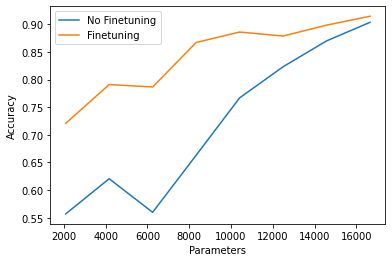

In [ ]:

fig, ax = plt.subplots()
ax.plot(results['params'], results['n_fine'], label='No Finetuning')
ax.plot(results['params'], results['fine'], label='Finetuning')
ax.legend()
plt.xlabel('Parameters')
plt.ylabel('Accuracy')
plt.show()

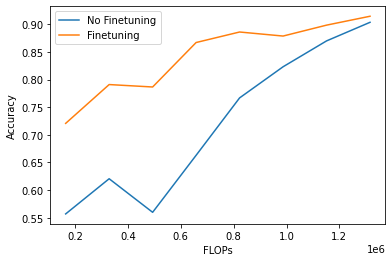

In [ ]:
fig, ax = plt.subplots()
ax.plot(results['flops'], results['n_fine'], label='No Finetuning')
ax.plot(results['flops'], results['fine'], label='Finetuning')
ax.legend()
plt.xlabel('FLOPs')
plt.ylabel('Accuracy')
plt.show()

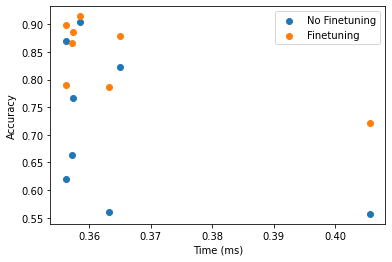

In [ ]:
fig, ax = plt.subplots()
ax.scatter(results['times'], results['n_fine'], label='No Finetuning')
ax.scatter(results['times'], results['fine'], label='Finetuning')
ax.legend()
plt.xlabel('Time (ms)')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
# Install ONNX
!pip3 install onnx

# Install tensorflow-addons
!pip3 install tensorflow-addons
!pip3 install tensorflow-probability

# Install onnx-tensorflow
!git clone https://github.com/onnx/onnx-tensorflow.git 
!cd onnx-tensorflow && pip3 install -e . 
# NOTE THERE IS A BUG. If you try and fail to import onnx_tf then just restart 
# your runtime after cloning the repo and it should work!

!pip3 install torchaudio
# Import libraries
import sys,os

# Add path to onnx-tensorflow
sys.path.insert(0, os.path.join(PROJECT_ROOT, '../onnx-tensorflow'))
sys.path.insert(0, PROJECT_ROOT)
print(sys.path)
import onnx
import torch
import torch.nn as nn
import numpy as np
import os
import tensorflow as tf
print(f"TensorFlow Version is: {tf.__version__}")
from onnx_tf.backend import prepare

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 42.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 53.6 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.6
    Uninstalling protobuf-3.19.6:
      Successfully uninstalled protobuf-3.19.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.11.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 34.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
fatal: destination path 

In [ ]:

file_name = 'pruned_mcu'
# Create a new TinyConv model
ONNX_PATH = os.path.join(ONNX_DIR, f'{file_name}.onnx')
TF_PATH = os.path.join(TF_DIR, f'{file_name}')

# Create a random input for model export
dummy_input = torch.autograd.Variable(torch.randn(1, 1960))

model_fp32_orig = copy.deepcopy(model_fp32)
pruned_model = structured_pruning(model_fp32_orig, nn.Conv2d, 0.3)

# Export model as .onnx file
torch.onnx.export(pruned_model.cpu(), dummy_input, ONNX_PATH)

# Load onnx model into a tensorflow model
onnx_model = onnx.load(ONNX_PATH)
tf_rep = prepare(onnx_model) 

# Export model as .pb file

tf_rep.export_graph(TF_PATH)


FLOAT_MODEL_TFLITE = os.path.join(TFLITE_DIR, f'float_{file_name}.tflite')
MODEL_TFLITE = os.path.join(TFLITE_DIR, f'quant_{file_name}.tflite')

float_converter = tf.lite.TFLiteConverter.from_saved_model(TF_PATH)
float_tflite_model = float_converter.convert()
float_tflite_model_size = open(FLOAT_MODEL_TFLITE, "wb").write(float_tflite_model)
print("Float model is %d bytes" % float_tflite_model_size)

converter = tf.lite.TFLiteConverter.from_saved_model(TF_PATH)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
def representative_dataset_gen():
    for i in range(100):
        data, _ = audio_processor.get_data(
            1, i*1, BACKGROUND_FREQUENCY, BACKGROUND_VOLUME_RANGE, TIME_SHIFT_MS, 'testing')
        flattened_data = np.array(data.flatten(), dtype=np.float32).reshape([1, 1960])
        yield [flattened_data]
converter.representative_dataset = representative_dataset_gen

tflite_model = converter.convert()
tflite_model_size = open(MODEL_TFLITE, "wb").write(tflite_model)
print("Quantized model is %d bytes" % tflite_model_size)

[autoreload of google.protobuf.internal.type_checkers failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/lib/python3.9/dist-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/usr/local/lib/python3.9/dist-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/usr/local/lib/python3.9/dist-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/usr/local/lib/python3.9/dist-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/usr/local/lib/python3.9/dist-packages/IPython/extensions/autoreload.py", line 266, in update_function
    setattr(old, name, getattr(new, name))
ValueError: CheckValue() requires a code object

Float model is 69344 bytes
Quantized model is 20064 bytes


In [ ]:

!apt-get update && apt-get -qq install xxd

MODEL_TFLITE = TFLITE_DIR + '/quant_temp_0.tflite' 
MODEL_TFLITE_MICRO = MICRO_DIR+'/micro_models.cc'

!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')

!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}

Get:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Get:2 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Hit:4 http://archive.ubuntu.com/ubuntu focal InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease [1,581 B]
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  Release
Get:8 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Get:10 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2,544 kB]
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Get:12 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [1,017 kB]
Get:13 http://ar

In [ ]:
!cat {MODEL_TFLITE_MICRO}

unsigned char g_model[] = {
  0x20, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x00, 0x00, 0x00, 0x00,
  0x14, 0x00, 0x20, 0x00, 0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00,
  0x0c, 0x00, 0x00, 0x00, 0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00,
  0x1c, 0x00, 0x00, 0x00, 0x94, 0x00, 0x00, 0x00, 0xec, 0x00, 0x00, 0x00,
  0xdc, 0x43, 0x00, 0x00, 0xec, 0x43, 0x00, 0x00, 0x98, 0x4d, 0x00, 0x00,
  0x03, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00,
  0x3a, 0xbb, 0xff, 0xff, 0x0c, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00,
  0x34, 0x00, 0x00, 0x00, 0x0f, 0x00, 0x00, 0x00, 0x73, 0x65, 0x72, 0x76,
  0x69, 0x6e, 0x67, 0x5f, 0x64, 0x65, 0x66, 0x61, 0x75, 0x6c, 0x74, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x88, 0xff, 0xff, 0xff,
  0x11, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x02, 0x00, 0x00, 0x00,
  0x31, 0x32, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00,
  0xf6, 0xbb, 0xff, 0xff, 0x04, 0x00, 0x00, 0x00, 0x1e, 0x00, 0x00, 0x00,
  0x6f, 0x

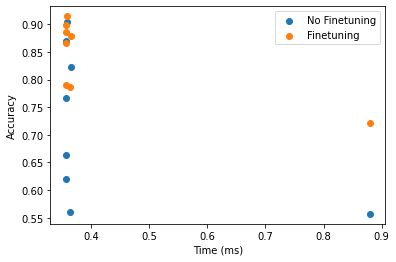

In [ ]:
results['times'] = [[0.35845375061035156, 0.35611820220947266, 0.36493945121765137, 0.3573753833770752, 0.35711169242858887, 0.36325693130493164, 0.3561699390411377, 0.88]]
fig, ax = plt.subplots()
ax.scatter(results['times'], results['n_fine'], label='No Finetuning')
ax.scatter(results['times'], results['fine'], label='Finetuning')
ax.legend()
plt.xlabel('Time (ms)')
plt.ylabel('Accuracy')
plt.show()

## 6.3 Unstructured Pruning

In this section, you will perform unstructured pruning on the TinyConv model and explore its effect on performance.

Following link will be helpful:
1. [torch.nn.utils.prune.l1_unstructured](https://pytorch.org/docs/stable/generated/torch.nn.utils.prune.l1_unstructured.html?highlight=unstructured#torch.nn.utils.prune.l1_unstructured)

2. [torch.nn.utils.prune.random_unstructured](https://pytorch.org/docs/stable/generated/torch.nn.utils.prune.random_unstructured.html?highlight=unstructured#torch.nn.utils.prune.random_unstructured)

2. [Torch pruning tutorial](https://pytorch.org/tutorials/intermediate/pruning_tutorial.html?highlight=prune)

Train size: 10556 Val size: 1333 Test size: 1368


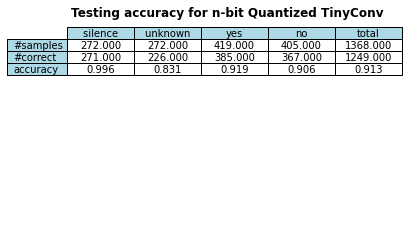

accuracy 0.9130116959064327


  0%|          | 0/8 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
import time
import os
from src.train_val_test_utils import plot_acc
from src.size_estimate import *


# Load the test data
test_time_data_loaders = make_data_loaders(
    audio_processor, device, 
    test_batch_size=1, valid_batch_size=1,
    num_workers=0
)
  

def prune_model_l1_unstructured(model, layer_type, proportion):
    # Prune the model's weights using L1 unstructured pruning
    for module in model.modules():
        if isinstance(module, layer_type):
            prune.l1_unstructured(module, 'weight', proportion)
            prune.remove(module, 'weight')
    return model


# Lists to store accuracy, finetuned accuracy, and trainable parameters for each pruning ratio
accuracies = []
finetuned_accuracies = []
trainable_parameters = []

# Iterate over different pruning ratios
for ratio_idx in range(8):
    # Calculate the actual pruning ratio as a float
    actual_ratio = ratio_idx / 8.

    # Create a copy of the model to prune
    pruned_model = copy.deepcopy(model_fp32)

    # Prune the model's weights using L1 unstructured pruning
    prune_model_l1_unstructured(pruned_model, nn.Conv2d, actual_ratio)

    # Evaluate the accuracy of the pruned model
    acc = plot_acc(
        test_time_data_loaders['testing'], pruned_model, audio_processor, device,
        'Testing', f'Pruned TinyConv w/ {actual_ratio} ratio', "float")
    print("accuracy", acc)

    # Create an optimizer for the pruned model
    optimizer_fp32 = create_optimizer(model=pruned_model, learning_rate=0.0001)

    # Define the checkpoint path for the pruned model
    checkpoint_path = os.path.join(TORCH_DIR, f"pruned_unstructured_finetune_checkpoint_{ratio_idx}.pt")

    # Convert the pruned model to the device
    pruned_model.to(device)

    # Set verbose to False and log_interval to 100
    verbose = False
    log_interval = 100

    # Get the number of batches in the train loader
    num_batches = len(train_loader)

    # Define the number of epochs to train for
    n_epoch = 8

    # Train the pruned model
    run_training(
        model=pruned_model, data_loaders=data_loaders, 
        n_epoch=n_epoch, log_interval=log_interval, 
        optimizer=optimizer_fp32, scheduler=None, 
        resume=False,
        checkpoint_path=checkpoint_path,
        verbose=verbose
    )

    # Evaluate the accuracy of the finetuned model
    ft_acc = plot_acc(
        test_time_data_loaders['testing'], pruned_model, audio_processor, device,
        'Testing', f'Pruned TinyConv w/ {actual_ratio} ratio and finetuning', "float")
    print("ft accuracy", ft_acc)

    # Calculate the number of trainable parameters for the pruned model
    num_trainable_params = (1. - actual_ratio) * count_trainable_parameters(pruned_model)

    # Append the results to the corresponding lists
    accuracies.append(acc)
    finetuned_accuracies.append(ft_acc)
    trainable_parameters.append(num_trainable_params)
#Define dictionary
results_2 = {}

#Append results
results_2['n_fine'] = accuracies

results_2['fine'] = finetuned_accuracies

results_2['counts'] = trainable_parameters
# Print the final results
print(accuracies, finetuned_accuracies, trainable_parameters)


In [42]:
#From previopsu run since it takes a while 
results_2 = {'n_fine':[0.9042397660818714, 0.902046783625731, 0.8947368421052632, 0.8640350877192983, 0.8135964912280702, 0.5197368421052632, 0.40789473684210525, 0.52046783625731],
'fine': [0.89546783625731, 0.9027777777777778, 0.8940058479532164, 0.8669590643274854, 0.8135964912280702, 0.5153508771929824, 0.40423976608187134, 0.5036549707602339],
'counts': [2085.0, 1824.375, 1563.75, 1303.125, 1042.5, 781.875, 521.25, 260.625]}

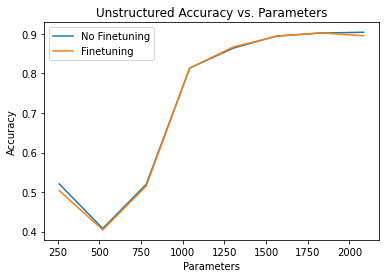

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [44]:

plt.figure()
plt.title("Unstructured Accuracy vs. Parameters")
plt.xlabel("Parameters")
plt.ylabel("Accuracy")
plt.plot(results_2['counts'], results_2['n_fine'], label="No Finetuning")
plt.plot(results_2['counts'], results_2['fine'],  label="Finetuning")
plt.legend()
plt.show()
plt.figure()